In [2]:
# create a virtual environment and install autokeras, matplotlib, pyarrow
# do not install keras or tensorflow one of them creates dependency issues

# Necessary imports
import autokeras as ak
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import pathlib
import pandas as pd
import math

import io
import requests
from PIL import Image

In [4]:
artists = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Artist.parquet.gzip')
artworks = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Artwork.parquet.gzip')
specialization = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Specialization.parquet.gzip')
movement = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Movement.parquet.gzip')
academy = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Academy.parquet.gzip')
medium = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Medium.parquet.gzip')
pictures = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/ArtistPicture.parquet.gzip')
places = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Places.parquet.gzip')
generated = pd.read_parquet('https://kuleuven-datathon-2023.s3.eu-central-1.amazonaws.com/data/Generated.parquet.gzip')

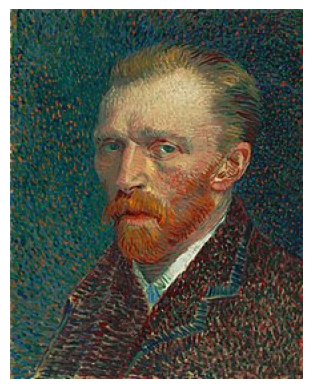

In [5]:
def display_artwork(url):
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
display_artwork(pictures.url.values[0])

In [10]:
# Collect all data

# Convolutional neural network (CNN) needs same shapes as input, so add zero padding untill max size of all images
new_width = 660
new_height = 660

# Resize images to make it computationally less heavy, might be removed in final regressor
img_size = 250

# Number of images loaded to train regressor, note some images will be removed because they do not have ratings
tot_im = 200


def get_train_data(label, start_id, end_id):
    x_data = [] 
    y_data = []
    url = label.image_url
    for i in range(start_id,end_id):#label.id:
        try:
            response = requests.get(url[i])
            image = Image.open(io.BytesIO(response.content))
            result = Image.new(image.mode, (new_width, new_height))
            result.paste(image, (0,0))
            result = result.resize((img_size, img_size))
            if ((np.asarray(result).shape == (img_size,img_size,3))
                and (not math.isnan(label.rating[i]))):
                x_data.append(np.asarray(result))
                y_data.append(label.rating[i])
        except Exception as e:
            print(e)
    return (x_data, y_data)

(x_train,y_train) =get_train_data(artworks, 0, tot_im)
tot_val_im = int(0.2*tot_im)
(x_val, y_val) = get_train_data(artworks, tot_im, tot_im+tot_val_im)
(x_test, y_test) = get_train_data(artworks, tot_im+tot_val_im, tot_im+tot_val_im+int(0.1*tot_im))
# fetch 100 images takes 1 minute

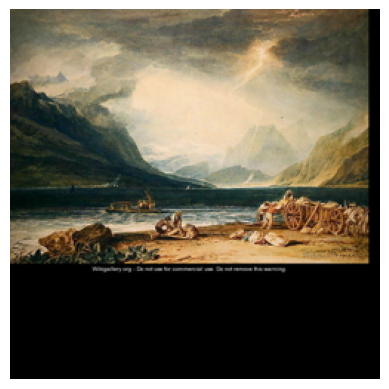

In [11]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
plt.imshow(x_test[1])
plt.axis("off")
plt.show()

In [14]:
## With autokeras does not yet work so ignore
### Initialize the image regressor.
reg = ak.ImageRegressor(overwrite=True, max_trials=1)
### Feed the image regressor with training data.
reg.fit(x_train, y_train, epochs=20)
### Predict with the best model.
predicted_y = reg.predict(x_test)
print(predicted_y)
### Evaluate the best model with testing data.
print(reg.evaluate(x_test, y_test))

Trial 1 Complete [00h 28m 49s]
val_loss: 15.682995796203613

Best val_loss So Far: 15.682995796203613
Total elapsed time: 00h 28m 49s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/20
5/5 [==============================] - 111s 17s/step - loss: 6993.1870 - mean_squared_error: 6993.1870
Epoch 2/20
5/5 [==============================] - 85s 16s/step - loss: 1107.6731 - mean_squared_error: 1107.6731
Epoch 3/20
5/5 [==============================] - 88s 17s/step - loss: 271.9612 - mean_squared_error: 271.9612
Epoch 4/20
5/5 [==============================] - 114s 22s/step - loss: 118.2113 - mean_squared_error: 118.2113
Epoch 5/20
5/5 [==============================] - 108s 21s/step - loss: 79.1992 - mean_squared_error: 79.1992
Epoch 6/20
5/5 [==============================] - 99s 20s/step - loss: 42.0139 - mean_squared_error: 42.0139
Epoch 7/20
5/5 [==============================] - 89s 16s/step - loss: 13.8283 - mean_squared_error: 13.8283
Epoch 8/20
5/5 [==============================] - 84s 16s/step - loss: 17.8475 - mean_squared_error: 17.8475
Epoch 9/20
5/5 [==============================] - 85s 17s/step - loss: 12.6991 - mean_squared_error: 12.6991
Epoc

INFO:tensorflow:Assets written to: .\image_regressor\best_model\assets


INFO:tensorflow:Assets written to: .\image_regressor\best_model\assets


1/1 [==============================] - 1s 1s/step
[[5.868423 ]
 [5.860081 ]
 [5.8757043]
 [5.847794 ]
 [5.8579984]
 [5.8690734]
 [5.8893433]
 [5.8770823]
 [5.8708673]]
1/1 [==============================] - 2s 2s/step - loss: 14.3558 - mean_squared_error: 14.3558
[14.35578727722168, 14.35578727722168]


In [17]:
model = reg.export_model()

In [20]:
model.summary()
#model.save('model_reg_autokeras_ratings_loss14.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 250, 250, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 250, 250, 3)      7         
 n)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 regression_head_1 (Dense)   (None, 1)                 131073

In [15]:
part_x_test = x_test[:]
y_test_pred = reg.predict(part_x_test)
print(y_test[:],y_test_pred)

1/1 [==============================] - 1s 1s/step
[10.  6. 10.  9. 10. 10. 10. 10. 10.] [[5.868423 ]
 [5.860081 ]
 [5.8757043]
 [5.847794 ]
 [5.8579984]
 [5.8690734]
 [5.8893433]
 [5.8770823]
 [5.8708673]]
